# Toronto Coffee Crawl

First, we load all the necessary libraries

In [1]:
pip install lxml html5lib beautifulsoup4 geocoder geopy

     |████████████████████████████████| 5.5MB 7.7MB/s eta 0:00:01                    | 1.8MB 7.7MB/s eta 0:00:01
     |████████████████████████████████| 122kB 38.7MB/s eta 0:00:01
     |████████████████████████████████| 102kB 26.0MB/s ta 0:00:01
     |████████████████████████████████| 112kB 36.9MB/s eta 0:00:01
  Using cached https://files.pythonhosted.org/packages/d2/3d/fa76db83bf75c4f8d338c2fd15c8d33fdd7ad23a9b5e57eb6c5de26b430e/click-7.1.2-py2.py3-none-any.whl
     |████████████████████████████████| 829kB 34.5MB/s eta 0:00:01
  Stored in directory: /home/jupyterlab/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
Successfully built future
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import folium 
import requests
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from geopy.distance import geodesic 
from sklearn.cluster import DBSCAN

Next, we scrape a table of Toronto postal codes from Wikipedia and create a dataframe

In [2]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
tables = pd.read_html(url)
df = tables[0]
df.head()

,Postal Code,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


Now, we drop all Boroughs which are "Not assigned"

In [3]:
df = df[df['Borough'] != 'Not assigned'].reset_index(drop=True)
df.head()

,Postal Code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


Now, we read in a csv file from Coursera which contains the latitude and longitude of each postal code. 

In [4]:
postal_coords = pd.read_csv('https://cocl.us/Geospatial_data')
postal_coords.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


We loop through the rows of our neighborhood data frame, and find the corresponding coordinates of each postal code

In [5]:
#make a column of just postal codes 
postal_codes = df['Postal Code']

#initialize lists for storing latitude and longitude
latitude = []
longitude = []

#get the latitude and longitude of each code 
for i in range(0,len(postal_codes)):
    
    #find index of the postal code's corresponding row in the coordinates dataframe 
    index = postal_coords['Postal Code'] == postal_codes[i]
    #get latitude and longitude 
    lat_long = np.asarray(postal_coords[index])[0]
    #assign latitude and longitude
    latitude.append(lat_long[1])
    longitude.append(lat_long[2])

We can now add the latitude and longitude columns to the data frame 

In [6]:
df['Latitude'] = latitude
df['Longitude'] = longitude
df.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


Now, we would like to use the Foursquare API, so we define our credentials and version

In [7]:
CLIENT_ID = 'YSJCWOWV450OWD45XLFHEYX0EBE5FZFQJF3H4BMQRJ0FEJ2C' # your Foursquare ID
CLIENT_SECRET = 'PR4SFYOC4RVTTEMXLHI1DD4BERWODDZN3BSJRNQRLP5YS3FH' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: YSJCWOWV450OWD45XLFHEYX0EBE5FZFQJF3H4BMQRJ0FEJ2C
CLIENT_SECRET:PR4SFYOC4RVTTEMXLHI1DD4BERWODDZN3BSJRNQRLP5YS3FH


Now, we define the following functions

In [8]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            100)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Now we use our functions to get venue data for each neighborhood

In [9]:
toronto_venues = getNearbyVenues(names=df['Neighborhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )
#display first five rows 
toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,Brookbanks Pool,43.751389,-79.332184,Pool
2,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
3,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
4,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant


We remove identical venues. 

In [10]:
#current shape
shape_before = np.shape(toronto_venues)

#drop duplicate venues 
toronto_venues = toronto_venues.drop_duplicates(subset=['Venue','Venue Latitude','Venue Longitude']).reset_index(drop=True)

#new shape
shape_after = np.shape(toronto_venues)

print("Before, there were", shape_before[0], "rows, but now there are", shape_after[0], "rows.")


Before, there were 2125 rows, but now there are 1690 rows.


Now, we create a new data frame with only the rows which correspond to coffe shops

In [11]:
toronto_coffee = toronto_venues[(toronto_venues['Venue Category'] == 'Coffee Shop')].reset_index(drop=True)
toronto_coffee.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop
1,"Regent Park, Harbourfront",43.654260,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,"Regent Park, Harbourfront",43.654260,-79.360636,Arvo,43.649963,-79.361442,Coffee Shop
3,"Regent Park, Harbourfront",43.654260,-79.360636,Rooster Coffee,43.651900,-79.365609,Coffee Shop
4,"Regent Park, Harbourfront",43.654260,-79.360636,Starbucks,43.651613,-79.364917,Coffee Shop


How many coffee shops do we have to work with?

In [12]:
pd.value_counts(toronto_coffee['Venue Category'])

Coffee Shop    135
Name: Venue Category, dtype: int64

Let us also create a dataframe consisting of the different possible hotels 

In [13]:
toronto_hotels = toronto_venues[(toronto_venues['Venue Category'] == 'Hotel')].reset_index(drop=True)
toronto_hotels.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.654260,-79.360636,Residence & Conference Centre,43.653040,-79.357040,Hotel
1,"Garden District, Ryerson",43.657162,-79.378937,The Grand Hotel & Suites Toronto,43.656449,-79.374110,Hotel
2,"Garden District, Ryerson",43.657162,-79.378937,Marriott Downtown at CF Toronto Eaton Centre,43.654728,-79.382422,Hotel
3,"Garden District, Ryerson",43.657162,-79.378937,Pantages Hotel & Spa,43.654498,-79.379035,Hotel
4,St. James Town,43.651494,-79.375418,The Omni King Edward Hotel,43.649191,-79.376006,Hotel


How many possible hotels are there to stay at?

In [14]:
pd.value_counts(toronto_hotels['Venue Category'])

Hotel    24
Name: Venue Category, dtype: int64

Let us view a map of these coffee shops (red) and hotels (blue).

In [15]:
# create map of Coffee Shops and Cafes using latitude and longitude from Foursquare data 
map_toronto = folium.Map(location=[43.6632, -79.3832], zoom_start=11)

# add red coffee shop markers to map
for lat, lng, name, neighborhood in zip(toronto_coffee['Venue Latitude'], toronto_coffee['Venue Longitude'], toronto_coffee['Venue'], toronto_coffee['Neighborhood']):
    label = '{}, {}'.format(name, neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto) 
    
# add blue hotel markers to map
for lat, lng, name, neighborhood in zip(toronto_hotels['Venue Latitude'], toronto_hotels['Venue Longitude'], toronto_hotels['Venue'], toronto_hotels['Neighborhood']):
    label = '{}, {}'.format(name, neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto) 
    
map_toronto

Now, in order to use DBSCAN to cluster the coffee shops, we must create a square distance matrix, X, where the entry X_ij corresponds to the distance from the i'th coffee shop to the j'th coffee shop (in kilometers). Note that the matrix is symmetric, so we only need to compute the upper diagonal. Since humans travel on the earth's surface, which is roughly spherical, we use the geodesic distance instead of the Euclidean distance. 

In [16]:
#initialize distance matrix of all zeroes
num_coffee_shops = np.shape(toronto_coffee)[0]
X = [[0 for rows in range(num_coffee_shops)] for columns in range(num_coffee_shops)] 


#loop through dataframe to fill upper half of distance matrix 
for i in range(0,num_coffee_shops):
    for j in range(i,num_coffee_shops):
    
        #get latitudes and longitudes from dataframe 
        lat1 = toronto_coffee.loc[i,'Venue Latitude']
        lon1 = toronto_coffee.loc[i,'Venue Longitude']
        lat2 = toronto_coffee.loc[j,'Venue Latitude']
        lon2 = toronto_coffee.loc[j,'Venue Longitude']
        
        #calculate distance
        distance = geodesic((lat1,lon1), (lat2,lon2)).km

        #enter distance into matrix
        X[i][j] = distance
        X[j][i] = distance 

Now we may use the DBSCAN algorithm to cluster the coffee shops.

In [17]:
#perform algorithm
coffee_clusters = DBSCAN(eps=.1666666667, min_samples=2, metric = 'precomputed').fit_predict(X)

#change first cluster index to be one instead of zero
coffee_clusters = coffee_clusters + 1

pd.value_counts(coffee_clusters)

0     49
13    17
4      7
7      5
9      4
24     3
22     3
3      3
17     3
16     3
14     3
6      3
11     3
8      3
1      2
2      2
5      2
12     2
10     2
23     2
25     2
15     2
18     2
19     2
20     2
21     2
26     2
dtype: int64

Cluster 13 is a clear winner (since the label 0 indicates noisy points). We may visualize the cluster densities with a histogram.

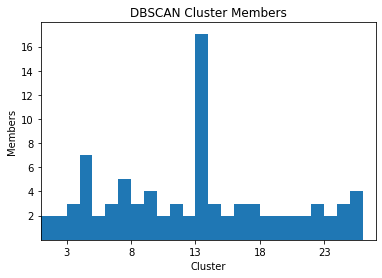

In [28]:
plt.hist(coffee_clusters, bins = (max(coffee_clusters)) , label = pd.unique(coffee_clusters), align = 'mid')
#adjust graph
plt.xticks(range(3,max(coffee_clusters),5))
plt.yticks(range(2,18,2))
plt.xlabel('Cluster')
plt.ylabel('Members')
plt.title('DBSCAN Cluster Members')
plt.xlim([1,27])
plt.ylim([0,18])
plt.show()

Now, for visualization purposes, let's change the color of coffee shops in Cluster 13 to yellow on our previous map.

In [30]:
#define a dataframe which only includes coffee shops in Cluster 0 
indices = (coffee_clusters == 13)
cluster_14 = toronto_coffee[indices].reset_index(drop=True)

# add red coffee shop markers to map
for lat, lng, name, neighborhood in zip(cluster_14['Venue Latitude'], cluster_14['Venue Longitude'], cluster_14['Venue'], cluster_14['Neighborhood']):
    label = '{}, {}'.format(name, neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='yellow',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=1,
        parse_html=False).add_to(map_toronto) 
    
#zoom in
map_toronto.location=[43.6432, -79.3832]
map_toronto.zoom_start = 15

map_toronto

The DBSCAN algorithm has successfully identified a dense cluster of 17 coffee shops, where an individual can walk from one to the next in approximately two minutes! Furthermore, the map also reveals that there is a hotel right in the middle of the cluster, namely The Fairmont Royal York. Thus, if an individual wants to go on a coffee crawl in Toronto, the Fairmont Royal York is definitely the best place to stay!